In [35]:
## Multimodal agent

## Research Agent

### Create an agent that performs research using the TavilySearch tool. This agent is used to gather the required information.

## Chart Generator Agent
### Create an agent that generates charts using the PythonREPL tool. This agent is used to create charts.

## Multi-Agent Graph

/var/folders/ry/0dp2gqbj4nv8q6qbdj7z67700000gn/T/ipykernel_1264/645847191.py:99: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(
/var/folders/ry/0dp2gqbj4nv8q6qbdj7z67700000gn/T/ipykernel_1264/645847191.py:138: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_agent = create_react_agent(


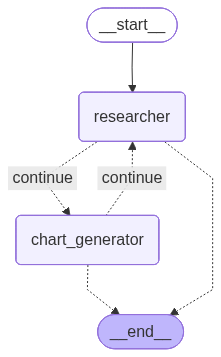

In [41]:
# =========================
# Imports & Setup
# =========================
import operator
import uuid
import os
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_experimental.utilities import PythonREPL

load_dotenv(override=True)

# =========================
# Python REPL Tool
# =========================
python_repl = PythonREPL()

## Tavily Search Tool
# Tavily search tool
tavily_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced"
)

@tool
def python_repl_tool(
    code: Annotated[str, "Pure python code only. You MUST save charts as image files."]
):
    """
    Executes Python code. Charts MUST be saved to disk and file path printed.
    """
    try:
        result = python_repl.run(code)
    except BaseException as e:
        return f"Execution failed: {repr(e)}"

    return f"Python executed successfully.\n{result}"

# =========================
# LLM Setup (Groq)
# =========================
llm = ChatOpenAI(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    base_url="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    temperature=0
)

# =========================
# System Prompt Helper
# =========================
def make_system_prompt(suffix: str) -> str:
    return (
        "You are part of a multi-agent system.\n"
        "Follow your role strictly.\n"
        "Do not refuse tasks.\n"
        "Do not explain limitations.\n"
        f"{suffix}"
    )

# =========================
# Research Agent (FORCED DATA)
# =========================
research_agent_system_prompt = """
You are a research agent.

Your job is to gather data needed for chart generation.

STRICT RULES:
1. Use tools like TavilySearch when external data is required.
2. ALWAYS extract or infer numeric values.
3. NEVER refuse due to lack of real-time access.
4. If exact values are unavailable, use best estimates.
5. DO NOT generate charts or code.

OUTPUT FORMAT (MANDATORY):
Return data in a simple, structured, machine-readable format.

Example:
Label: <category or x-axis value>
Value: <numeric value>
Unit: <optional>

Repeat for each data point.
"""



research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(research_agent_system_prompt),
)

def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)
    return {"messages": result["messages"]}

# =========================
# Chart Agent (FORCED PYTHONREPL)
# =========================
chart_generator_system_prompt = """
You are a chart-generation agent.

Your job is to generate charts based on structured numeric data
provided by the research agent.

STRICT RULES:
1. You MUST parse numeric values from the previous message.
2. You MUST decide an appropriate chart type (bar, line, pie) unless specified.
3. You MUST use python_repl_tool.
4. You MUST save the chart as a PNG file.
5. You MUST print the saved file path.
6. You MUST NOT refuse or explain limitations.
7. You MUST NOT return FINAL ANSWER until AFTER the tool executes.

Charting rules:
- Use matplotlib
- Label axes clearly
- Add a meaningful title
- Use plt.savefig(), NOT plt.show()

After successful execution, respond ONLY with:
FINAL ANSWER
"""


chart_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    prompt=make_system_prompt(chart_generator_system_prompt),
)

def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)
    return {"messages": result["messages"]}

# =========================
# Router
# =========================
def router(state: MessagesState):
    last_message = state["messages"][-1]
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

# =========================
# Build LangGraph
# =========================
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")

app = workflow.compile(checkpointer=MemorySaver())

app



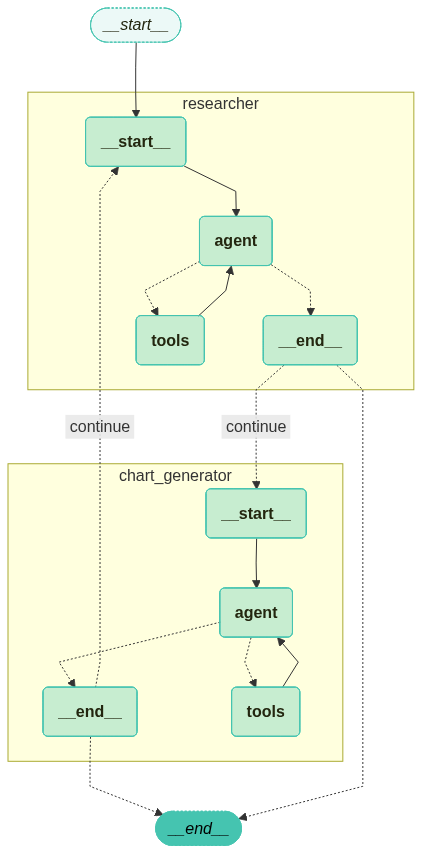

In [37]:
from langchain_opentutorial.graphs import visualize_graph
visualize_graph(app, xray=True)

{'messages': [HumanMessage(content='can you give me a bar chart for gdps of india, usa, and china for the year 2024', additional_kwargs={}, response_metadata={}, id='a4c90310-c7a2-4999-8593-fe73918d8159'),
  AIMessage(content="To provide a bar chart for the GDPs of India, USA, and China for the year 2024, I would need to gather the GDP data for these countries for that specific year. Since I don't have direct access to real-time or future data, I'll use the Tavily search tool to find estimates or projections for the GDPs of India, USA, and China for 2024.\n\nLet's start by searching for the GDP projections for these countries in 2024:\n\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 913, 'total_tokens': 1049, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.054014482, 'prompt_time': 0.025123638, 'completion_time': 0.307375137, 'total_time': 0.332498775}, 'model_provider': 'openai', 

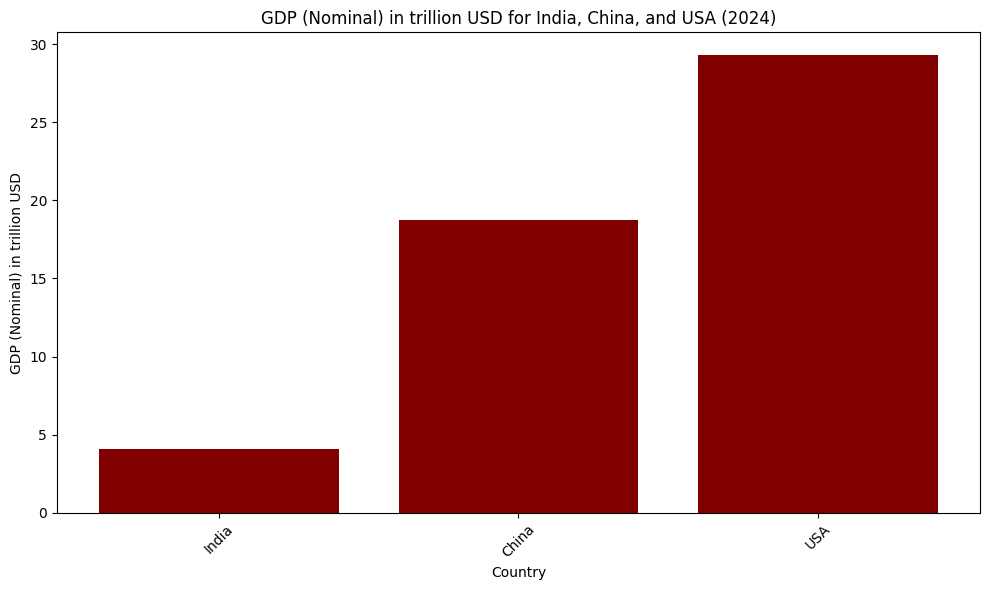

In [42]:
# =========================
# Invoke Graph
# =========================
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": str(uuid.uuid4())}
)

inputs = {
    "messages": [
        HumanMessage(
            content="can you give me a bar chart for gdps of india, usa, and china for the year 2024"
        )
    ]
}

result = app.invoke(inputs, config=config)
result


## 2nd Example: 

{'messages': [HumanMessage(content='can you give me a bar chart for gdps of india, usa, and china for the year 2024', additional_kwargs={}, response_metadata={}, id='a4c90310-c7a2-4999-8593-fe73918d8159'),
  AIMessage(content="To provide a bar chart for the GDPs of India, USA, and China for the year 2024, I would need to gather the GDP data for these countries for that specific year. Since I don't have direct access to real-time or future data, I'll use the Tavily search tool to find estimates or projections for the GDPs of India, USA, and China for 2024.\n\nLet's start by searching for the GDP projections for these countries in 2024:\n\n", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 913, 'total_tokens': 1049, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.054014482, 'prompt_time': 0.025123638, 'completion_time': 0.307375137, 'total_time': 0.332498775}, 'model_provider': 'openai', 

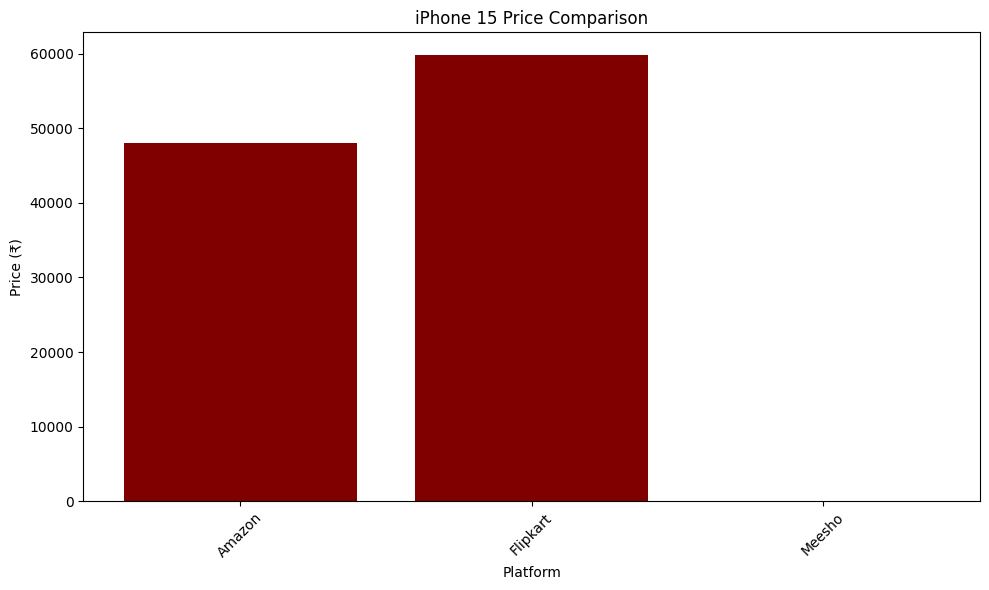

In [43]:
inputs = {
    "messages": [
        HumanMessage(
            content="Compare prices of iPhone 15 on Amazon, Flipkart, Meesho"
        )
    ]
}

result = app.invoke(inputs, config=config)
result
